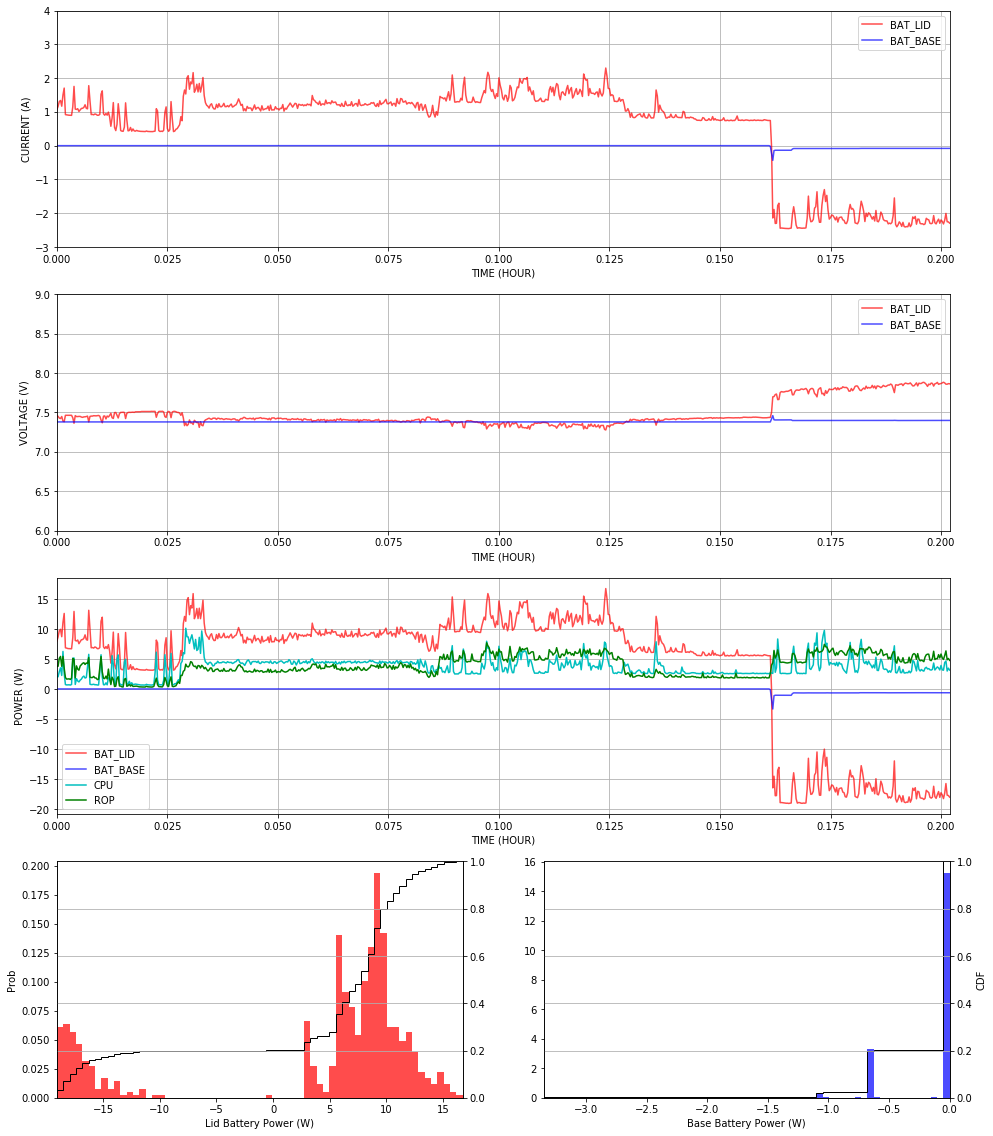

In [152]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

def uj2uw(t,e):
    uw = [(e[1]-e[0])/(t[1]-t[0])/1e6]
    for t0,t1,e0,e1 in zip(t[:-1],t[1:],e[:-1],e[1:]):
        uw.append((e1-e0)/(t1-t0)/1e6)
    return np.array(uw)

PLOT_ALPHA=0.7
df = pd.read_csv('/tmp/mon.csv')

cpu_uw = uj2uw(df['time'],df['cpu_uj'])
sys_uw = uj2uw(df['time'],df['sys_uj'])

#t = df['time']
t = np.arange(len(df['time'])).astype(float)
t = (t - t[0])/60/60

plt.figure(figsize=(16,20),facecolor='white')
gs = gridspec.GridSpec(4, 2)
ax0 = plt.subplot(gs[0, :])
ax1 = plt.subplot(gs[1, :])
ax2 = plt.subplot(gs[2, :])
ax3 = plt.subplot(gs[3, 0])
ax4 = plt.subplot(gs[3, 1])

ax0.plot(t, df["i0"]/1e6, 'r', label='BAT_LID', alpha=PLOT_ALPHA)
ax0.plot(t, df["i1"]/1e6, 'b', label='BAT_BASE', alpha=PLOT_ALPHA)
ax0.set_ylim([-3,4])
ax0.set_xlim([min(t),max(t)])
ax0.grid(True)
ax0.legend()

ax1.plot(t, df["v0"]/1e6, 'r', label='BAT_LID', alpha=PLOT_ALPHA)
ax1.plot(t, df["v1"]/1e6, 'b', label='BAT_BASE', alpha=PLOT_ALPHA)
ax1.set_ylim([6,9])
ax1.set_xlim([min(t),max(t)])
ax1.grid(True)
ax1.legend()

ax2.plot(t, df["i0"]*df["v0"]/1e12, 'r', label='BAT_LID', alpha=PLOT_ALPHA)
ax2.plot(t, df["i1"]*df["v0"]/1e12, 'b', label='BAT_BASE', alpha=PLOT_ALPHA)
ax2.plot(t, cpu_uw, 'c', label='CPU')
ax2.plot(t, sys_uw*2 - cpu_uw, 'g', label='ROP')
ax2.set_xlim([min(t),max(t)])
ax2.grid(True)
ax2.legend()

ax0.set_xlabel('TIME (HOUR)')
ax1.set_xlabel('TIME (HOUR)')
ax2.set_xlabel('TIME (HOUR)')

ax0.set_ylabel('CURRENT (A)')
ax1.set_ylabel('VOLTAGE (V)')
ax2.set_ylabel('POWER (W)');

p0 = df["i0"]*df["v0"]/1e12
p1 = df["i1"]*df["v0"]/1e12

#p0 = p0[p0>1]
#p1 = p1[p1>1]

num_bins = 64

ax3_1 = ax3.twinx()
ax4_1 = ax4.twinx()

ax3_1.grid(True)
ax4_1.grid(True)

# the histogram of the data
n, bins, patches = ax3.hist(p0, num_bins, normed=1, facecolor='red', alpha=PLOT_ALPHA)
ax3_1.hist(p0, bins=bins, normed=1, histtype='step', color='black', cumulative=True, label='CDF')

n, bins, patches = ax4.hist(p1, num_bins, normed=1, facecolor='blue', alpha=PLOT_ALPHA)
ax4_1.hist(p1, bins=bins, normed=1, histtype='step', color='black', cumulative=True, label='CDF')

ax3.set_ylabel('Prob')
ax4_1.set_ylabel('CDF')

ax3.set_xlabel('Lid Battery Power (W)')
ax4.set_xlabel('Base Battery Power (W)')
ax3.set_xlim([min(p0),max(p0)])
ax4.set_xlim([min(p1),max(p1)])
ax3_1.set_ylim([0,1])
ax4_1.set_ylim([0,1]);

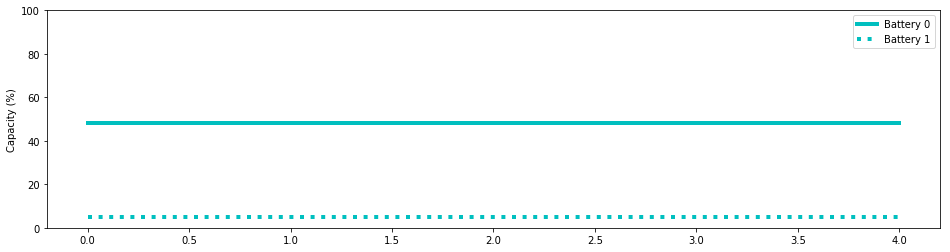

In [111]:
fig,ax=plt.subplots(figsize=(16,4))
ax.plot(df["c0"], 'c', lw=4, label='Battery 0')
ax.plot(df["c1"], 'c:', lw=4, label='Battery 1')
ax.set_ylim([0,100])
ax.set_ylabel('Capacity (%)');
ax.legend()